In [1]:
import json
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.patches import Patch
import numpy as np
import pandas as pd
import seaborn as sns

DATA_PATH = Path.cwd().parents[0] / "data"
OUT_PATH = Path.cwd().parents[0] / "figures"

# studies on animals

The file `assessments-animals.json` contains the mapping from unified assessment names (e.g. BBB) to the names encountered in and extracted from individual publications (e.g. BBB scale, BBB locomotor scale, etc.).

In [2]:
with open(DATA_PATH / "assessments-animals.json", "r", encoding="utf-8") as f:
    assessments = json.load(f)
assessments_animals = {}
for k, v in assessments.items():
    try:
        for assessment in v:
            assessments_animals[assessment] = k
    except:
        print(k, v)

In [3]:
data_extracted = pd.read_csv(
    filepath_or_buffer=DATA_PATH / "data-extracted-20230818.csv"
).loc[
    :,
    [
        "Authors",
        "Year",
        "Title",
        "DOI or PMID",
        "Included/exclude",
        "Species",
        "Name/type of asessement",
        "Name of assessment harmonised",
    ],
]
animals_included = data_extracted[data_extracted["Included/exclude"] == "included"]
animals_included = animals_included[animals_included["Species"] != "human"]

In [4]:
# check that all assessment names as extracted have been mapped to a common term
assessments_cleaned = []
assessments_not_harmonised = []
for _, exp in animals_included.iterrows():
    exp_assessments = exp.loc["Name/type of asessement"]
    try:
        exp_assessments = exp_assessments.strip()
        exp_assessments = exp_assessments.replace(";", ",")
        exp_assessments = exp_assessments.split(",")
        for item in exp_assessments:
            item = item.strip()
            assessments_cleaned.append(assessments_animals[item])
    except:
        if exp.loc["Name/type of asessement"] is np.nan:
            pass
        else:
            assessments_not_harmonised.append(exp.loc["Name/type of asessement"])


In [5]:
assessments_not_harmonised

[]

## reshape assessment data

...to long format and use harmonised assessment names instead of particular name from publication.

In [6]:
animals_included.columns


Index(['Authors', 'Year', 'Title', 'DOI or PMID', 'Included/exclude',
       'Species', 'Name/type of asessement', 'Name of assessment harmonised'],
      dtype='object')

In [7]:
animals_included[animals_included["DOI or PMID"].isna()]


,Authors,Year,Title,DOI or PMID,Included/exclude,Species,Name/type of asessement,Name of assessment harmonised


In [8]:
animals_assessments_long = pd.DataFrame(
    columns=["DOI.or.PMID", "Authors", "Year", "Species", "Assessment"]
)
for _, exp in animals_included.iterrows():
    exp_assessments = exp.loc["Name/type of asessement"]
    try:
        exp_assessments = exp_assessments.strip()
        exp_assessments = exp_assessments.replace(";", ",")
        exp_assessments = exp_assessments.split(",")
        for item in exp_assessments:
            item = item.strip()
            animals_assessments_long = pd.concat(
                [
                    animals_assessments_long,
                    pd.DataFrame(
                        {
                            "DOI.or.PMID": [exp["DOI or PMID"]],
                            "Authors": [exp["Authors"]],
                            "Year": [exp["Year"]],
                            "Species": [exp["Species"]],
                            "Assessment": [assessments_animals[item]],
                        }
                    ),
                ],
                ignore_index=True,
            )
    except:
        print(exp["DOI or PMID"], exp["Authors"], exp["Name/type of asessement"])


In [9]:
animals_assessments_long

,DOI.or.PMID,Authors,Year,Species,Assessment
0,10.1016/j.brainres.2008.09.047,Pinzon et al.,2008,rats,BBB
1,10.1016/j.expneurol.2013.06.023,Sharp et al,2013,rats,BBB
2,10.1016/j.expneurol.2013.06.023,Sharp et al,2013,rats,grid walking test
3,10.1016/j.expneurol.2013.06.023,Sharp et al,2013,rats,gait analysis
4,10.1016/j.expneurol.2013.06.023,Sharp et al,2013,rats,mechanical reactivity
...,...,...,...,...,...
843,10.18632/aging.103125,Wang et al,2020,rats,BBB
844,10.3389/fnmol.2019.00018,Li et al,2019,mice,BMS
845,10.1016/j.neulet.2020.135263,Lin et al,2020,mice,BMS
846,10.1016/j.lfs.2020.117351,Li et al,2020,mice,BMS


In [10]:
animals_assessments_long[animals_assessments_long["Assessment"] == "rearing"]

,DOI.or.PMID,Authors,Year,Species,Assessment
350,10.1172/JCI130391,Sun et al.,2020,mice,rearing
431,10.1016/j.expneurol.2010.06.018,Lee et al.,2010,rats,rearing
436,10.1016/j.expneurol.2010.06.018,Lee et al.,2010,rats,rearing
455,10.1097/BRS.0b013e3181d2d6c5,Lee et al.,2010,rats,rearing
611,10.1016/j.expneurol.2010.11.016,Popovich et al.,2012,rats,rearing
612,10.1016/j.expneurol.2010.11.016,Popovich et al.,2012,rats,rearing
614,10.1016/j.expneurol.2010.11.016,Popovich et al.,2012,rats,rearing


In [11]:
animals_assessments_long["DOI.or.PMID"].unique().shape


(377,)

In [12]:
animals_assessments_long["Species"].value_counts()


Species
rats          727
mice           59
rabbit         22
cats           17
dogs           10
guinea pig      8
other           5
Name: count, dtype: int64

In [13]:
animals_assessments_long["Assessment"].value_counts()


Assessment
BBB                                275
inclined plane test                106
Tarlov scale                        52
locomotor (other)                   46
gait analysis                       44
mechanical reactivity               41
somatosensory evoked potentials     40
BMS                                 26
ladder walk test                    26
thermal reactivity                  23
grid walking test                   23
Gale scale                          23
pain                                22
motor evoked potentials             22
beam walk test                      15
reaching or retrieval               12
electrophysiology (other)            9
swimming                             7
rearing                              7
spinal cord evoked potentials        4
micturition                          4
toe spread test                      4
composite scores                     3
trunk muscle activity                3
grooming                             3
spinal cord bl

In [14]:
animals_assessments_long.to_csv(DATA_PATH / "animals-assessments-long.csv")

## basic visualisation

The grouping has been performed to assess how commonly different dimensions of function are assessed (see Section 2.5 in manuscript).

In [15]:
animal_assessments_grouping = {
    "locomotion": [
        "BBB",
        "BMS",
        "beam walk test",
        "gait analysis",
        "grid walking test",
        "ladder walk test",
        "inclined plane test",
        "Tarlov scale",
        "swimming",
        "locomotor (other)",
    ],
    "forelimb function": [
        # "staircase test",
        "grip strength",
        "grooming",
        "rearing",
        "reaching or retrieval",
    ],
    "sensory.and.pain": [
        "mechanical reactivity",
        "thermal reactivity",
        "pain",
        "toe spread test",
        "other reflexes",
    ],
    "electrophysiology": [
        # "EMG",
        "motor evoked potentials",
        "somatosensory evoked potentials",
        "spinal cord evoked potentials",
        "electrophysiology (other)",
    ],
    "other.functional": [
        "Gale scale",
        "composite scores",
        "hindfoot bar grab test",
        "spinal cord blood flow",
        "trunk muscle activity",
        "micturition",
    ],
}


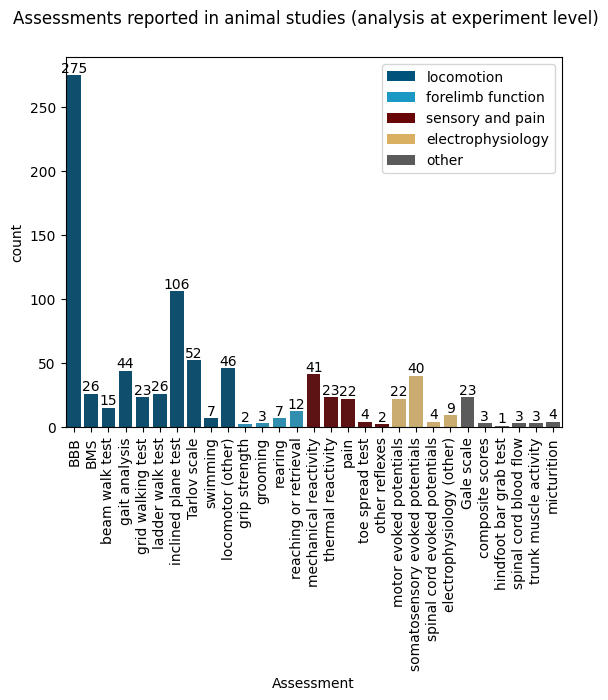

In [16]:
fig, ax = plt.subplots()
sns.countplot(
    data=animals_assessments_long,
    x="Assessment",
    order=[
        *animal_assessments_grouping["locomotion"],
        *animal_assessments_grouping["forelimb function"],
        *animal_assessments_grouping["sensory.and.pain"],
        *animal_assessments_grouping["electrophysiology"],
        *animal_assessments_grouping["other.functional"],
    ],
    palette=len(animal_assessments_grouping["locomotion"]) * ["#00547b"]
    + len(animal_assessments_grouping["forelimb function"]) * ["#1c98c4"]
    + len(animal_assessments_grouping["sensory.and.pain"]) * ["#690608"]
    + len(animal_assessments_grouping["electrophysiology"]) * ["#d9b061"]
    + len(animal_assessments_grouping["other.functional"]) * ["#5b5b5b"],
    orient="v",
    ax=ax,
)
ax.bar_label(ax.containers[0])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
ax.legend(
    handles=[
        Patch(facecolor="#00547b", label="locomotion"),
        Patch(facecolor="#1c98c4", label="forelimb function"),
        Patch(facecolor="#690608", label="sensory and pain"),
        Patch(facecolor="#d9b061", label="electrophysiology"),
        Patch(facecolor="#5b5b5b", label="other"),
    ],
    loc="upper right",
)
fig.suptitle("Assessments reported in animal studies (analysis at experiment level)")
plt.show()

# studies on humans

In [17]:
humans_included = data_extracted[
    (data_extracted["Included/exclude"] == "included")
    & (data_extracted["Species"] == "human")
]
humans_included.head()

,Authors,Year,Title,DOI or PMID,Included/exclude,Species,Name/type of asessement,Name of assessment harmonised
32,Cragg et al,2019,A Longitudinal Study of the Neurologic Safety ...,10.1007/s13311-019-00713-8,included,human,marked recovery,"neurological (motor and sensory), injury severity"
42,Bracken et al,1990,"A randomized, controlled trial of methylpredni...",10.1056/NEJM199005173222001,included,human,"pinprick, light touch, motor function scale",neurological (motor and sensory)
43,Bracken et al,1990,"A randomized, controlled trial of methylpredni...",10.1056/NEJM199005173222001,included,human,"pinprick, light touch, motor function scale",neurological (motor and sensory)
417,Aminmansour et al.,2016,Effects of progesterone and vitamin D on outco...,10.1080/10790268.2015.1114224,included,human,ASIA motor and sensory scores,neurological (motor and sensory)
552,Sunshine et al.,2017,Methylprednisolone Therapy in Acute Traumatic ...,10.1213/ANE.0000000000001906,included,human,"ASIA motor score, FIM motor score","neurological (motor), functional (mobility)"


In [18]:
human_assessments_long = pd.DataFrame(
    columns=["DOI.or.PMID", "Authors", "Year", "Species", "Assessment"]
)
for _, exp in humans_included.iterrows():
    exp_assessments = exp.loc["Name of assessment harmonised"]
    try:
        exp_assessments = exp_assessments.split(",")
        for item in exp_assessments:
            item = item.strip()
            human_assessments_long = pd.concat(
                [
                    human_assessments_long,
                    pd.DataFrame(
                        {
                            "DOI.or.PMID": [exp["DOI or PMID"]],
                            "Authors": [exp["Authors"]],
                            "Year": [exp["Year"]],
                            "Species": [exp["Species"]],
                            "Assessment": [item],
                        }
                    ),
                ],
                ignore_index=True,
            )
    except:
        print(exp["DOI or PMID"], exp["Authors"], exp["Name/type of asessement"])
human_assessments_long = pd.get_dummies(
    human_assessments_long,
    columns=["Assessment"],
    prefix={"Assessment": ""},
    prefix_sep="",
)
human_assessments_long.set_index("DOI.or.PMID", inplace=True)
human_assessments_long.sort_values("Year", inplace=True)
human_assessments_long.head()


,Authors,Year,Species,electrophysiology,functional (general),functional (mobility and general),functional (mobility and spasticity),functional (mobility),injury severity,neurological (motor and sensory),neurological (motor),neurological (other)
DOI.or.PMID,,,,,,,,,,,,
10.1056/NEJM199005173222001,Bracken et al,1990,human,False,False,False,False,False,False,True,False,False
10.1056/NEJM199005173222001,Bracken et al,1990,human,False,False,False,False,False,False,True,False,False
10.3171/jns.1992.76.1.0023,Bracken et al.,1992,human,False,False,False,False,False,False,True,False,False
10.3171/jns.1992.76.1.0023,Bracken et al.,1992,human,False,False,False,False,False,False,True,False,False
10.3171/jns.1993.79.4.0500,Bracken and Holford,1993,human,False,False,False,False,False,False,True,False,False


In [19]:
human_assessments_long.loc[
    human_assessments_long["neurological (motor and sensory)"], "neurological (motor)"
] = True
human_assessments_long.loc[
    human_assessments_long["neurological (motor and sensory)"], "neurological (sensory)"
] = True
human_assessments_long.loc[
    human_assessments_long["functional (mobility and general)"], "functional (general)"
] = True
human_assessments_long.loc[
    human_assessments_long["functional (mobility and general)"], "functional (mobility)"
] = True
human_assessments_long.loc[
    human_assessments_long["functional (mobility and spasticity)"],
    "functional (mobility)",
] = True
human_assessments_long.loc[
    human_assessments_long["functional (mobility and spasticity)"],
    "functional (spasticity)",
] = True
human_assessments_long.loc[
    human_assessments_long["neurological (sensory)"].isna(), "neurological (sensory)"
] = False
human_assessments_long.loc[
    human_assessments_long["functional (spasticity)"].isna(), "functional (spasticity)"
] = False
human_assessments_long = human_assessments_long.loc[
    :,
    [
        "functional (general)",
        "functional (mobility)",
        "functional (spasticity)",
        "injury severity",
        "neurological (motor)",
        "neurological (sensory)",
        "neurological (other)",
        "electrophysiology",
    ],
]
human_assessments_long = human_assessments_long.astype(bool)
human_assessments_long


,functional (general),functional (mobility),functional (spasticity),injury severity,neurological (motor),neurological (sensory),neurological (other),electrophysiology
DOI.or.PMID,,,,,,,,
10.1056/NEJM199005173222001,False,False,False,False,True,True,False,False
10.1056/NEJM199005173222001,False,False,False,False,True,True,False,False
10.3171/jns.1992.76.1.0023,False,False,False,False,True,True,False,False
10.3171/jns.1992.76.1.0023,False,False,False,False,True,True,False,False
10.3171/jns.1993.79.4.0500,False,False,False,False,True,True,False,False
10.3171/jns.1993.79.4.0500,False,False,False,False,True,True,False,False
10.1097/00007632-200301010-00009,False,False,False,False,True,True,False,False
10.1097/01.brs.0000250273.28483.5c,False,False,False,False,True,False,False,False
10.1097/PHM.0b013e318168bbec,False,False,False,False,True,False,False,False


In [20]:
human_assessments = (
    human_assessments_long.groupby("DOI.or.PMID", as_index=True).sum().astype(bool)
)

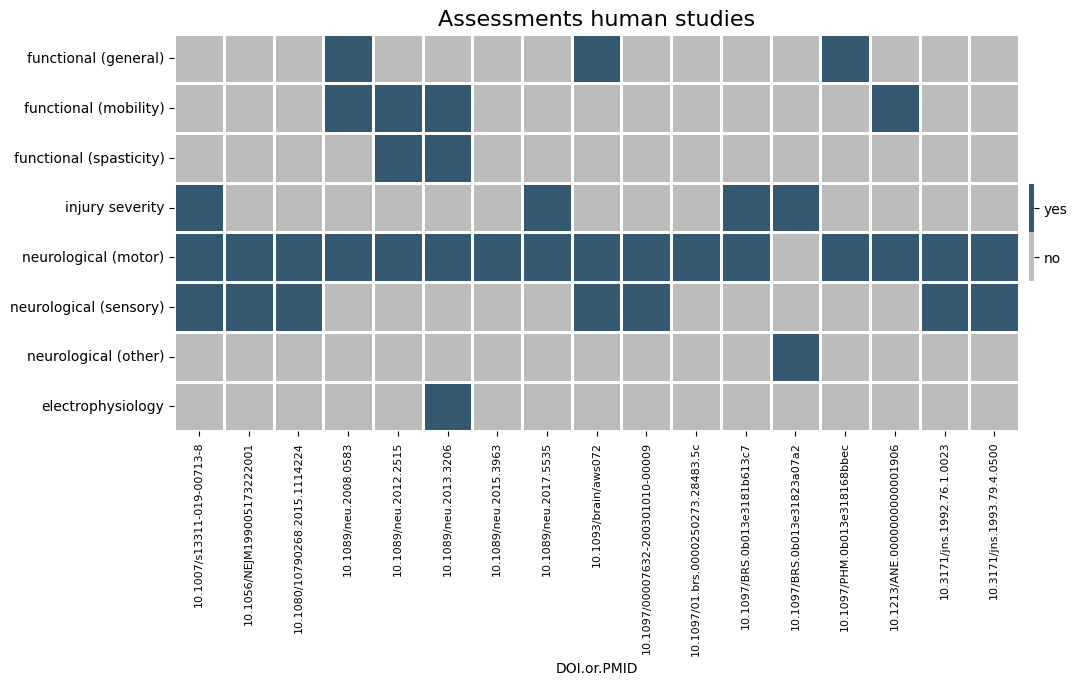

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
cmap = LinearSegmentedColormap.from_list("custom", ["#bcbcbc", "#365972"], 2)
sns.heatmap(
    human_assessments.transpose(),
    square=True,
    linewidths=1,
    linecolor="w",
    cmap=cmap,
    cbar_kws={"shrink": 0.15, "pad": 0.01, "location": "right"},
    ax=ax,
)
cbar = ax.collections[0].colorbar
cbar.set_ticks([0.25, 0.75])
cbar.set_ticklabels(["no", "yes"])
ax.set_xticklabels(ax.get_xticklabels(), fontdict={"size": 8})
ax.set_title("Assessments human studies", fontdict={"size": 16})
fig.tight_layout()
plt.show()